### F1

In [ ]:
%pip install transformers
%pip install asyncpraw
%pip install nest_asyncio
import asyncpraw
import pandas as pd
from transformers import pipeline
import torch
import re
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Define subreddits and keywords
subreddits = ["formula1", "F1Technical", "formuladank"]
f1_keywords = []

reddit = asyncpraw.Reddit(
    client_id="IdcgD6XBkW_S3gfnJmClSg",
    client_secret="GK9YuQ1SHFqNCl0boQHYDdopHy-v1g",
    user_agent="digital-probe by u/tmakos"
)

# Initialize pipelines with GPU support
ner = pipeline("token-classification", model="dslim/bert-base-NER", device=device)
sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", device=device)

def process_text(text):
    if not isinstance(text, str):
        return pd.NA
    image_url_pattern = re.compile(r'(https?://\S+(?:jpg|jpeg|png))', re.IGNORECASE)
    if image_url_pattern.search(text):
        return pd.NA
    return text

def get_named_entities(text):
    if not isinstance(text, str):
        return ''
    ner_results = ner(text, aggregation_strategy="simple")
    entities = []
    current_entity = ""
    current_type = ""

    for item in ner_results:
        if item['word'].startswith('##'):
            current_entity += item['word'][2:]  # Remove '##' and append
        else:
            if current_entity:
                entities.append(f"{current_entity} ({current_type})")
            current_entity = item['word']
            current_type = item['entity_group']

    if current_entity:
        entities.append(f"{current_entity} ({current_type})")

    return ', '.join(entities)

def get_sentiment(text):
    if not isinstance(text, str) or not text.strip():
        return pd.NA
    try:
        result = sentiment_analyzer(text, truncation=True, max_length=512)
        return result[0]['label']
    except Exception as e:
        print(f"Error during sentiment analysis: {str(e)}")
        return pd.NA


async def get_top_comments(submission, limit=20):
    try:
        submission.comment_sort = 'top'
        comments = await submission.comments()
        await comments.replace_more(limit=0)
        top_comments = []
        async for comment in comments:
            if len(top_comments) >= limit:
                break
            top_comments.append((comment.body, comment.author.name if comment.author else "[deleted]"))
        return top_comments
    except Exception as e:
        print(f"Error getting comments for submission {submission.id}: {str(e)}")
        return []

async def analyze_reddit_posts(subreddit_name, time_filter="year", limit=100):
    posts_data = []
    print(f"Analyzing top posts from subreddit: {subreddit_name}")

    subreddit = await reddit.subreddit(subreddit_name)
    try:
        async for submission in subreddit.top(time_filter=time_filter, limit=limit):
            try:
                print(f"Processing submission: {submission.id}")

                # Check if the submission is deleted or removed
                if not submission.author or submission.removed_by_category:
                    print(f"Skipping deleted/removed submission: {submission.id}")
                    continue

                top_comments = await get_top_comments(submission)

                processed_title = process_text(submission.title)
                processed_selftext = process_text(submission.selftext)

                post_data = {
                    "title": processed_title,
                    "text": processed_selftext,
                    "subreddit": submission.subreddit.display_name,
                    "score": submission.score,
                    "source": submission.url,
                    "url": submission.url,
                    "num_comments": submission.num_comments,
                    "created_datetime": pd.to_datetime(submission.created_utc, unit="s"),
                    "selftext": processed_selftext,
                    "named_entities": get_named_entities(f"{processed_title} {processed_selftext}"),
                    "sentiment_title": get_sentiment(processed_title),
                    "sentiment_text": get_sentiment(processed_selftext),
                    "author": submission.author.name if submission.author else "[deleted]",
                }

                for i, (comment, author) in enumerate(top_comments[:10], 1):
                    processed_comment = process_text(comment)
                    post_data[f"top_comments_{i}"] = processed_comment
                    post_data[f"sentiment_comment_{i}"] = get_sentiment(processed_comment)
                    post_data[f"named_entities_comment_{i}"] = get_named_entities(processed_comment)
                    post_data[f"comment_author_{i}"] = author

                posts_data.append(post_data)
                print(f"Successfully processed submission: {submission.id}")

                # Add a small delay to respect rate limits
                await asyncio.sleep(0.5)
            except Exception as e:
                print(f"Error processing submission {submission.id}: {str(e)}")
                continue

    except Exception as e:
        print(f"Error in subreddit top posts retrieval: {str(e)}")

    print(f"Collected {len(posts_data)} posts from subreddit: {subreddit_name}")

    return pd.DataFrame(posts_data)


def standardize_entries_with_log_and_similarity_enhanced(dataframe, name_column, type_column, threshold=0.799):
    # Ensure that both columns are treated as Series and handle NaN values
    dataframe[name_column] = dataframe[name_column].fillna("Unknown")
    dataframe[type_column] = dataframe[type_column].fillna("")
    unique_values = dataframe[[name_column, type_column]].drop_duplicates()

    # Combine the name and type columns for similarity check
    combined_column = unique_values[name_column] + " " + unique_values[type_column]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(combined_column)
    cosine_similarities = linear_kernel(tfidf_matrix)

    similarity_groups = defaultdict(list)
    similarity_scores = {}
    for i in range(len(cosine_similarities)):
        for j in range(i + 1, len(cosine_similarities)):
            if cosine_similarities[i, j] >= threshold:
                entry_i = combined_column.iloc[i]
                entry_j = combined_column.iloc[j]
                similarity_groups[entry_i].append(entry_j)
                similarity_groups[entry_j].append(entry_i)
                similarity_scores[(entry_i, entry_j)] = cosine_similarities[i, j]
                similarity_scores[(entry_j, entry_i)] = cosine_similarities[i, j]

    standardized_entries = {}
    for entry, similar_entries in similarity_groups.items():
        if entry not in standardized_entries:
            standardized_entries[entry] = entry
            for similar_entry in similar_entries:
                standardized_entries[similar_entry] = entry

    change_log_data = []
    for i, row in unique_values.iterrows():
        combined_value = row[name_column] + " " + row[type_column]
        new_value = standardized_entries.get(combined_value, combined_value)
        if combined_value != new_value:
            similarity_score = similarity_scores.get((combined_value, new_value), 0)
            change_log_data.append({
                'Original Value': combined_value,
                'New Value': new_value,
                'Similarity Score': similarity_score
            })

    # Map the standardized names back to the DataFrame
    standardized_map = {row[name_column] + " " + row[type_column]: standardized_entries.get(row[name_column] + " " + row[type_column], row[name_column] + " " + row[type_column]) for i, row in unique_values.iterrows()}
    dataframe['Standardized Name'] = dataframe.apply(lambda row: standardized_map[row[name_column] + " " + row[type_column]], axis=1)

    change_log_df = pd.DataFrame(change_log_data)
    return dataframe, change_log_df



async def main():
    print("Starting main function")

    # Analyze top posts from each subreddit
    subreddit_dfs = []
    for subreddit in subreddits:
        print(f"Analyzing top posts for subreddit: {subreddit}")
        df = await analyze_reddit_posts(subreddit)
        if not df.empty:
            subreddit_dfs.append(df)
        else:
            print(f"No data collected for subreddit: {subreddit}")

    if subreddit_dfs:
        final_df = pd.concat(subreddit_dfs, ignore_index=True)
        final_df.drop_duplicates(subset=['url'], inplace=True)  # Remove any duplicate posts
        print(f"Total unique posts after combining: {len(final_df)}")

        final_df, change_log_df = standardize_entries_with_log_and_similarity_enhanced(final_df, 'title', 'subreddit')

        final_df.to_csv("reddit_formula1_top_posts_analysis.csv", index=False)
        change_log_df.to_csv("standardization_change_log.csv", index=False)
    else:
        print("No data collected. Unable to create final dataframe.")

    print("Main function completed")

import asyncio
import nest_asyncio
from asyncio import get_event_loop

# For Jupyter Notebook, use this instead of if __name__ == "__main__":
nest_asyncio.apply()

async def run_async_code():
    await main()

# Execute the function
asyncio.run(run_async_code())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 1.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Starting main function
Analyzing top posts for subreddit: formula1
Analyzing top posts from subreddit: formula1
Processing submission: 12gc1gs


<ipython-input-1-c23e10693a0d>:101: DeprecationWarning: `Submission.comments` is now a property and no longer needs to be awaited. This will raise an error in a future version of Async PRAW.
  top_comments = await get_top_comments(submission)
<ipython-input-1-c23e10693a0d>:101: DeprecationWarning: Using CommentForest as an asynchronous iterator has been deprecated and will be removed in a future version.
  top_comments = await get_top_comments(submission)


Successfully processed submission: 12gc1gs
Processing submission: 141jtll
Successfully processed submission: 141jtll
Processing submission: 1agiwur
Successfully processed submission: 1agiwur
Processing submission: 13up602
Successfully processed submission: 13up602
Processing submission: 12khxd4
Successfully processed submission: 12khxd4
Processing submission: 13l43fx
Successfully processed submission: 13l43fx
Processing submission: 1ag83xn
Successfully processed submission: 1ag83xn
Processing submission: 13foo0x
Successfully processed submission: 13foo0x
Processing submission: 12v1c09
Successfully processed submission: 12v1c09
Processing submission: 1449r7p
Successfully processed submission: 1449r7p
Processing submission: 13npdr3
Successfully processed submission: 13npdr3
Processing submission: 1bmd6x3
Successfully processed submission: 1bmd6x3
Processing submission: 13ucu03
Successfully processed submission: 13ucu03
Processing submission: 17yau5b
Successfully processed submission: 17y

In [ ]:
df = pd.read_csv('/content/reddit_formula1_top_posts_analysis.csv')
df.shape

(291, 54)

Entity Standardization Change Log:
      Original Value         New Value
1          Instagram            Ingram
8              Alpin            Alpine
10                MA               May
15             FERRA           Ferrari
16        Ferrari F1      Ferrari F399
..               ...               ...
896             Gram               GRA
918             SF23           SF - 23
922  McLaren MP4 / 4  McLaren MP4 / 23
940             Fred               Red
956          Piastri             Piast

[223 rows x 2 columns]


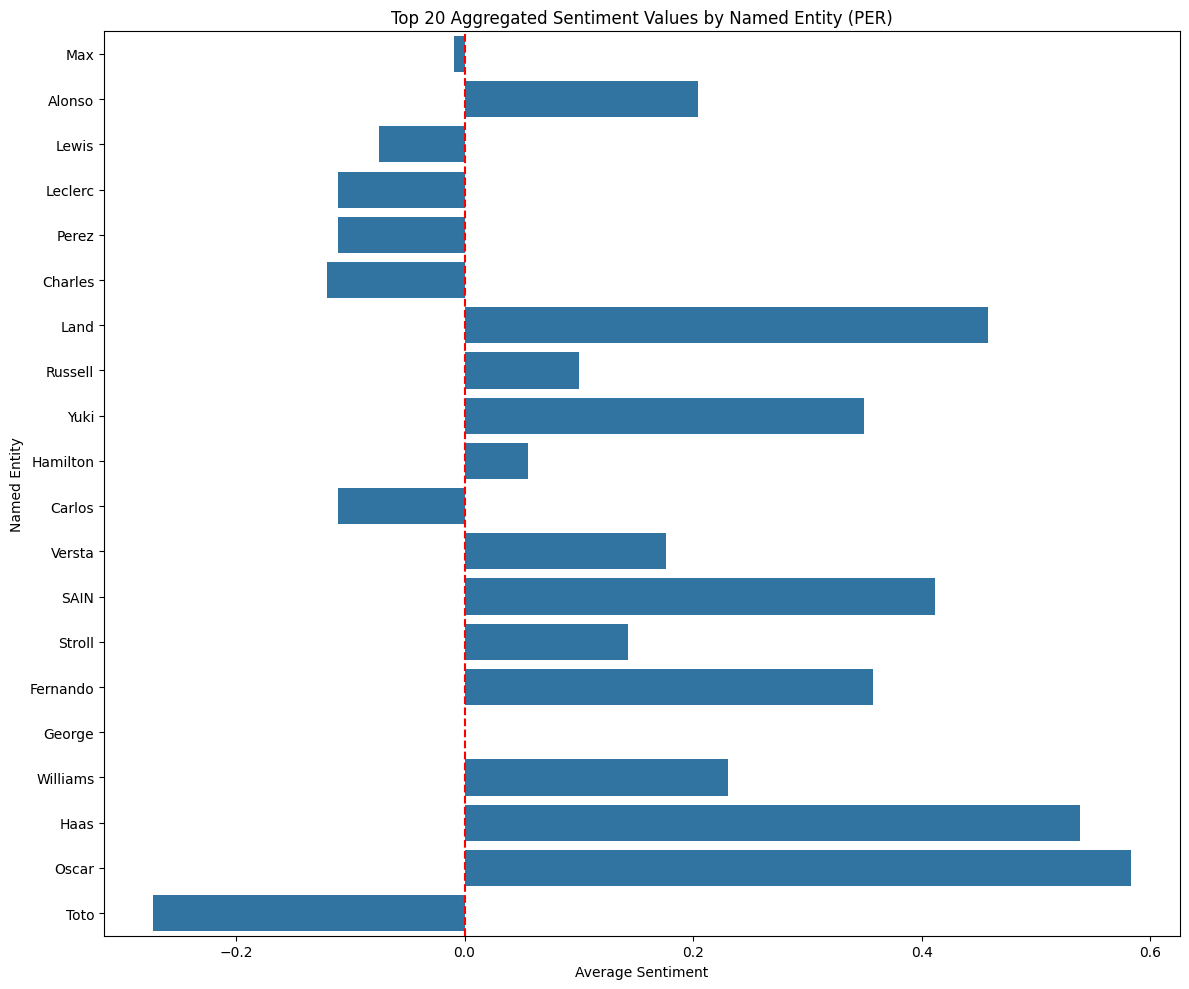

Top 20 Entities with Sentiment Analysis:
       Entity  Sentiment_Value  Count
195       Max        -0.008929    112
11     Alonso         0.204082     49
167     Lewis        -0.075000     40
165   Leclerc        -0.111111     27
243     Perez        -0.111111     27
45    Charles        -0.120000     25
160      Land         0.458333     24
271   Russell         0.100000     20
327      Yuki         0.350000     20
111  Hamilton         0.055556     18
40     Carlos        -0.111111     18
313    Versta         0.176471     17
272      SAIN         0.411765     17
293    Stroll         0.142857     14
82   Fernando         0.357143     14
93     George         0.000000     14
320  Williams         0.230769     13
106      Haas         0.538462     13
234     Oscar         0.583333     12
304      Toto        -0.272727     11


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
import re


# Function to preprocess the name column
def preprocess_name(name):
    # Convert to lowercase and remove non-alphanumeric characters
    return re.sub(r'[^a-z0-9\s]', '', str(name).lower())

def are_names_similar(name1, name2, threshold=80):
    # Use fuzzy string matching to compare names
    return fuzz.ratio(preprocess_name(name1), preprocess_name(name2)) >= threshold

def standardize_ner_results(df):
    ner_columns = [col for col in df.columns if col.startswith('named_entities')]
    all_entities = []

    # Collect all unique entities across all NER columns
    for col in ner_columns:
        entities = df[col].dropna().astype(str).str.split(', ').explode()
        all_entities.extend(entities)

    all_entities = pd.Series(all_entities).unique()

    # Create a DataFrame with 'name' and 'type' columns
    entities_split = pd.DataFrame([e.split(' (') for e in all_entities if '(' in e], columns=['name', 'type'])
    entities_split['type'] = entities_split['type'].str.replace(')', '')

    # Create standardization mapping
    standardization_map = {}
    for i, row in entities_split.iterrows():
        name = row['name']
        if name not in standardization_map:
            similar_names = []
            for j, other_row in entities_split.iterrows():
                if i != j and are_names_similar(name, other_row['name']):
                    similar_names.append(other_row['name'])

            if similar_names:
                # Choose the most frequent name as the standard
                all_names = [name] + similar_names
                standard_name = max(all_names, key=all_names.count)
                for similar_name in all_names:
                    standardization_map[similar_name] = standard_name
            else:
                standardization_map[name] = name

    # Apply standardization to the DataFrame
    for col in ner_columns:
        df[f'{col}_standardized'] = df[col].astype(str).apply(
            lambda x: ', '.join([f"{standardization_map.get(e.split(' (')[0], e.split(' (')[0])} ({e.split(' (')[1]}"
                                 for e in x.split(', ') if '(' in e]) if x != 'nan' else ''
        )

    # Create change log
    change_log = pd.DataFrame({
        'Original Value': standardization_map.keys(),
        'New Value': standardization_map.values()
    })
    change_log = change_log[change_log['Original Value'] != change_log['New Value']]

    return df, change_log

# Function to extract PER entities and their sentiments
def extract_per_entities(row, comment_num):
    entities = row[f'named_entities_comment_{comment_num}_standardized']
    sentiment = row[f'sentiment_comment_{comment_num}']

    if pd.isna(entities) or pd.isna(sentiment):
        return []

    entities = str(entities).split(', ')
    return [(entity.split(' (')[0], sentiment) for entity in entities if entity.endswith('(PER)')]

# Main processing loop
df, change_log = standardize_ner_results(df)

# Print change log
print("Entity Standardization Change Log:")
print(change_log)

# Aggregate sentiments for all comments
all_entities = []
for i in range(1, 11):
    all_entities.extend(df.apply(lambda row: extract_per_entities(row, i), axis=1).sum())

# Create a DataFrame with the aggregated data
entity_df = pd.DataFrame(all_entities, columns=['Entity', 'Sentiment'])

# Convert sentiment to numeric values
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
entity_df['Sentiment_Value'] = entity_df['Sentiment'].map(sentiment_map)

# Group by entity and calculate the average sentiment
grouped_df = entity_df.groupby('Entity').agg({
    'Sentiment_Value': 'mean',
    'Entity': 'count'
}).rename(columns={'Entity': 'Count'}).reset_index()

grouped_df = grouped_df.sort_values('Count', ascending=False)

# Filter for the top 20 entities
top_entities_df = grouped_df.head(20)

# Plot the results
plt.figure(figsize=(12, 10))
sns.barplot(x='Sentiment_Value', y='Entity', data=top_entities_df, orient='h')
plt.title('Top 20 Aggregated Sentiment Values by Named Entity (PER)')
plt.xlabel('Average Sentiment')
plt.ylabel('Named Entity')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

# Print the data to verify
print("Top 20 Entities with Sentiment Analysis:")
print(top_entities_df)

Entity modifications applied.


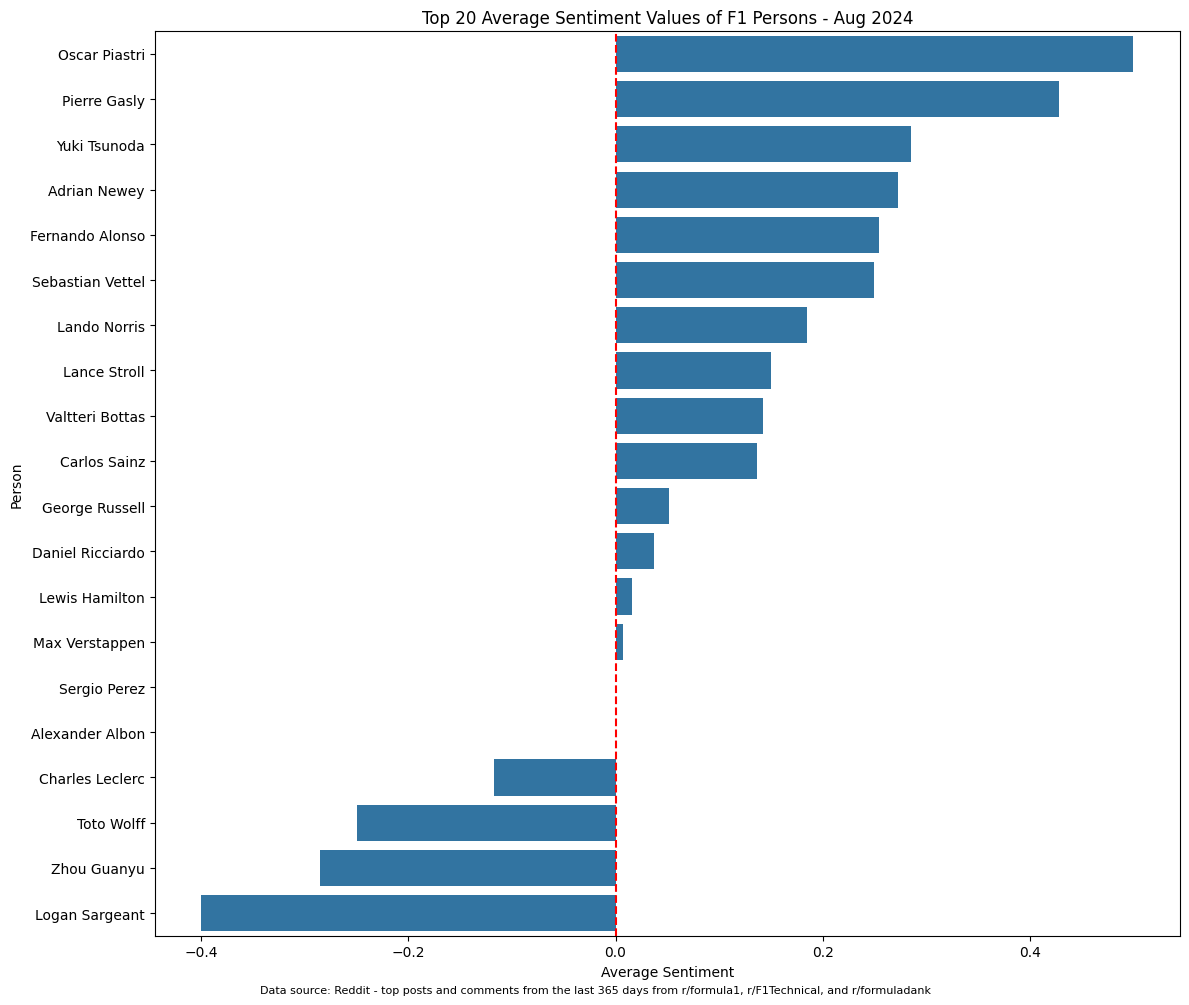

Top 20 Entities with Sentiment Analysis:


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def modify_entities(df, change_dict, ner_columns):
    df_modified = df.copy()

    for col in ner_columns:
        df_modified[col] = df_modified[col].astype(str)

        for old_entity, new_entity in change_dict.items():
            df_modified[col] = df_modified[col].apply(
                lambda x: ', '.join([f"{new_entity} ({e.split('(')[1]}" if e.strip().split(' (')[0].lower() == old_entity.lower() else e for e in x.split(', ') if '(' in e])
            )

    print("Entity modifications applied.")
    return df_modified

def extract_per_entities(row, comment_num):
    entities = row[f'named_entities_comment_{comment_num}']
    sentiment = row[f'sentiment_comment_{comment_num}']

    if pd.isna(entities) or pd.isna(sentiment):
        return []

    entities = str(entities).split(', ')
    return [(entity.split(' (')[0], sentiment) for entity in entities if '(PER)' in entity.upper()]


change_dict = {
    # Max Verstappen
    "Versta": "Max Verstappen",
    "Max": "Max Verstappen",
    "Verstappen": "Max Verstappen",
    "Verstappe": "Max Verstappen",
    "Max Verstappe": "Max Verstappen",
    "Vers": "Max Verstappen",
    "Max Versta": "Max Verstappen",

    # Lewis Hamilton
    "LewisH": "Lewis Hamilton",
    "Lewis": "Lewis Hamilton",
    "Hamilton": "Lewis Hamilton",
    "Ham": "Lewis Hamilton",

    # Sergio Perez
    "Checo": "Sergio Perez",
    "Perez": "Sergio Perez",
    "Chec": "Sergio Perez",

    # Lando Norris
    "Land": "Lando Norris",
    "Lando": "Lando Norris",
    "Norris": "Lando Norris",

    # George Russell
    "Russell": "George Russell",
    "George": "George Russell",
    "Russel": "George Russell",

    # Oscar Piastri
    "Oscar": "Oscar Piastri",
    "Piastri": "Oscar Piastri",
    "Piast": "Oscar Piastri",
    "Pi": "Oscar Piastri",

    # Fernando Alonso
    "Alonso": "Fernando Alonso",
    "Fernando": "Fernando Alonso",

    # Charles Leclerc
    "Lecle": "Charles Leclerc",
    "Charles": "Charles Leclerc",
    "Leclerc": "Charles Leclerc",

    # Daniel Ricciardo
    "Ricciardo": "Daniel Ricciardo",
    "Daniel": "Daniel Ricciardo",
    "Danny Ric": "Daniel Ricciardo",
    "Danny": "Daniel Ricciardo",
    "Ricrdo": "Daniel Ricciardo",

    # Alexander Albon
    "Albon": "Alexander Albon",
    "Alex": "Alexander Albon",

    # Pierre Gasly
    "Gasly": "Pierre Gasly",
    "Gas": "Pierre Gasly",
    "Pierre": "Pierre Gasly",

    # Carlos Sainz
    "Sainz": "Carlos Sainz",
    "Carlos": "Carlos Sainz",
    "Sai": "Carlos Sainz",

    # Kimi Räikkönen
    "Kimi": "Kimi Räikkönen",
    "Raikkonen": "Kimi Räikkönen",
    "Kim": "Kimi Räikkönen",
    "Raik": "Kimi Räikkönen",

    # Zhou Guanyu
    "Jo": "Zhou Guanyu",
    "Zhou": "Zhou Guanyu",
    "Guanyu": "Zhou Guanyu",

    # Toto Wolff
    "Toto": "Toto Wolff",
    "Wolff": "Toto Wolff",

    # Lance Stroll
    "Stroll": "Lance Stroll",
    "Lance": "Lance Stroll",
    "St": "Lance Stroll",

    # Valtteri Bottas
    "Botta": "Valtteri Bottas",
    "Bottas": "Valtteri Bottas",
    "Valtteri": "Valtteri Bottas",
    "Val": "Valtteri Bottas",
    "Valtter": "Valtteri Bottas",

    # Peter Bonnington
    "Bono": "Peter Bonnington",
    "Bonnington": "Peter Bonnington",

    # Sebastian Vettel
    "Vettel": "Sebastian Vettel",
    "Seb": "Sebastian Vettel",
    "Sebastian": "Sebastian Vettel",
    "Vette": "Sebastian Vettel",

    # Nico Rosberg
    "Rosberg": "Nico Rosberg",
    "Nico": "Nico Rosberg",

    # Michael Schumacher
    "Schumacher": "Michael Schumacher",
    "Michael": "Michael Schumacher",
    "Schum": "Michael Schumacher",

    # Mick Schumacher
    "Mick": "Mick Schumacher",

    # Williams Racing
    "Williams": "Williams Racing",

    # Nico Hülkenberg
    "Hulk": "Nico Hülkenberg",
    "Hulkenberg": "Nico Hülkenberg",
    "Hülkenberg": "Nico Hülkenberg",
    "Nico Hu": "Nico Hülkenberg",

    # Yuki Tsunoda
    "Yuki": "Yuki Tsunoda",
    "Tsunoda": "Yuki Tsunoda",

    # Esteban Ocon
    "Ocon": "Esteban Ocon",
    "Esteban": "Esteban Ocon",

    # Kevin Magnussen
    "Magnussen": "Kevin Magnussen",
    "Kevin": "Kevin Magnussen",
    "KMag": "Kevin Magnussen",
    "Magnusssen": "Kevin Magnussen",

    "Logan": "Logan Sargeant",

    # Others
    "Newey": "Adrian Newey",
    "Horner": "Christian Horner",
    "Brundle": "Martin Brundle",
    "Martin": "Martin Brundle",
    "Button": "Jenson Button",
    "Webber": "Mark Webber",
    "Senna": "Ayrton Senna",
    "Prost": "Alain Prost",
    "Fangio": "Juan Manuel Fangio",
    "Lauda": "Niki Lauda",
    "Mansell": "Nigel Mansell",
    "Andretti": "Mario Andretti",
    "Clark": "Jim Clark",
    "Stewart": "Jackie Stewart",
    "Hakkinen": "Mika Hakkinen",
    "Massa": "Felipe Massa",
    "Grosjean": "Romain Grosjean",
    "Kvyat": "Daniil Kvyat",
    "Latifi": "Nicholas Latifi",
    "Mazepin": "Nikita Mazepin",
}

ner_columns = [col for col in df.columns if col.startswith('named_entities')]
df_modified = modify_entities(df, change_dict, ner_columns)

# Aggregate sentiments for all comments
all_entities = []
for i in range(1, 11):
    all_entities.extend(df_modified.apply(lambda row: extract_per_entities(row, i), axis=1).sum())

# Create a DataFrame with the aggregated data
entity_df = pd.DataFrame(all_entities, columns=['Entity', 'Sentiment'])

# Convert sentiment to numeric values
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
entity_df['Sentiment_Value'] = entity_df['Sentiment'].map(sentiment_map)

# Group by entity and calculate the average sentiment
grouped_df = entity_df.groupby('Entity').agg({
    'Sentiment_Value': 'mean',
    'Entity': 'count'
}).rename(columns={'Entity': 'Count'}).reset_index()

grouped_df = grouped_df.sort_values('Count', ascending=False)

# Filter for the top 20 entities
top_entities_df = grouped_df.head(25)

# Drop Haas
top_entities_df = top_entities_df[top_entities_df['Entity'] != 'Haas']
# Drop God
top_entities_df = top_entities_df[top_entities_df['Entity'] != 'God']
# Drop Williams Racing
top_entities_df = top_entities_df[top_entities_df['Entity'] != 'Williams Racing']

# Drop Michael Schumaher
top_entities_df = top_entities_df[top_entities_df['Entity'] != 'Michael Schumacher']

# Drop To
top_entities_df = top_entities_df[top_entities_df['Entity'] != 'To']

# Order by sentimen
top_entities_df = top_entities_df.sort_values('Sentiment_Value', ascending=False)

# Plot the results
plt.figure(figsize=(12, 10))
sns.barplot(x='Sentiment_Value', y='Entity', data=top_entities_df, orient='h')
plt.title('Top 20 Average Sentiment Values of F1 Persons - Aug 2024')
plt.xlabel('Average Sentiment')
plt.ylabel('Person')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
# Add footnote
footnote_text = "Data source: Reddit - top posts and comments from the last 365 days from r/formula1, r/F1Technical, and r/formuladank"
plt.figtext(0.5, 0.001, footnote_text, ha='center', fontsize=8, wrap=True)

plt.tight_layout()
plt.show()
plt.show()

# Print the data to verify
print("Top 20 Entities with Sentiment Analysis:")
grouped_df.to_csv("reddit_formula1_comprehensive_analysis_standardized_modified.csv", index=False)